In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
%matplotlib nbagg
import ipywidgets as ipw
import matplotlib.pyplot as plt

from IPython.display import display
from pathlib import Path

import functions as fn

pulses = None
files = None
f = None

<IPython.core.display.Javascript object>


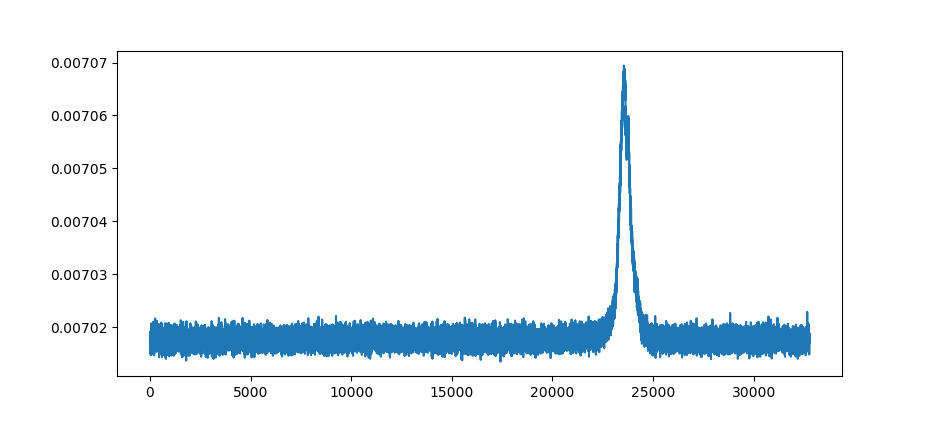

In [3]:
def on_path_change(value):
    global files
    global f
    path = Path(value['new'])
    files = sorted(path.glob('*.h5'))
    f = sorted([a.name for a in files])
    if len(f) > 0:
        ctrl_file.options = f
        ctrl_file.disabled = False
        btn_select.disabled = False
    else:
        ctrl_file.options = []
        ctrl_file.disabled = True
        btn_select.disabled = True

def read_data(b):
    global pulses
    to_read = files[f.index(ctrl_file.value)]
    pulses = fn.read_data(to_read)
    plt.clf()
    plt.plot(fn.get_mean_profile(pulses))
    plt.show()
    
ctrl_path = ipw.Text(
    placeholder='Path to data directory',
    description='Path:',
    disabled=False
)

ctrl_file = ipw.Dropdown(
    options=[],
    description='Select file:',
    disabled=True
)

btn_select = ipw.Button(
    description='Accept',
    disabled=True

)

ctrl_path.observe(on_path_change, names='value')
btn_select.on_click(read_data)
ipw.VBox([ipw.HBox([ctrl_path, ctrl_file]), ipw.HBox([btn_select])])
